In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis,integral,integral_Lmin_Lmax
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq
import fitting
from scipy.optimize import minimize

2024-10-29 02:09:55.161391: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [4]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [5]:
d_desi = Planck18.distmod(z_desi).value

In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.4)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

42124


In [8]:
apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [9]:
def eff(m,b,m0):
    eff = jnp.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff

ln_posterior = fitting.ln_posterior(eff)

def neg_likelihood(params,apr_mag,k,mu,apr_mag_err):
    m0,b,x = params
    #Lmin = abs_mag_to_L(apr_mag_r.max()-k_rr.mean()-d_desi.mean()-x)/L_star
    
    log_likelihood = ln_posterior(m0, b, x, apr_mag, k, mu, apr_mag_err,0.0001)
    return -log_likelihood

In [10]:
initial_guess = [18,0.5,1.85]
bounds = [(0,20),(10,20),(0,3)]

result = minimize(
    neg_likelihood, 
    initial_guess, 
    args=(apr_mag_r, k_rr, d_desi, apr_mag_r_err), 
    method='L-BFGS-B',
    bounds=bounds
)

optimal_params = result.x
optimal_likelihood = -result.fun  

print(f"Optimal parameters: m0 = {optimal_params[0]}, b = {optimal_params[1]}, x = {optimal_params[2]}")
print(f"Maximum likelihood value: {optimal_likelihood}")

Optimal parameters: m0 = 19.096216282010253, b = 10.0, x = 0.0
Maximum likelihood value: 253694.3786738453


In [11]:
'''
params = [16.0259,0.45,1.85]
neg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)
'''

'\nparams = [16.0259,0.45,1.85]\nneg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)\n'

100%|██████████| 100/100 [1:03:27<00:00, 38.08s/it]


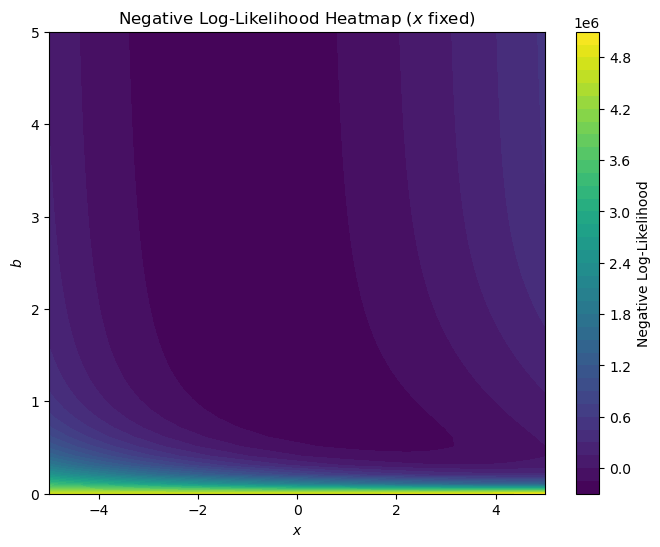

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the parameter grid for m0 and b
x_values = np.linspace(-5, 5, 100)
#m0_values = np.linspace(1.5, 2.5, 10)
b_values = np.linspace(0, 5, 50)

# Calculate likelihoods for a fixed x
#x_fixed = 1.7
m0_fixed = 18
#b_fixed = 0.5
likelihoods = np.zeros((len(x_values), len(b_values)))

for i, x in enumerate(tqdm(x_values)):
    for j, b in enumerate(b_values):
        params = [m0_fixed, b, x]
        likelihoods[i, j] = neg_likelihood(params,apr_mag_r, k_rr, d_desi, apr_mag_r_err)

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(x_values, b_values, likelihoods.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('$x$')
plt.ylabel('$b$')
plt.title('Negative Log-Likelihood Heatmap ($x$ fixed)')
plt.show()